In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# LPS, Bilateral
# Square wave
def square_wave(t):
    return 1*(t%1 < 0.5) - 1*(t%1 >= 0.5)

# Plot square wave
t = np.arange(-10, 10, 0.1)
plt.plot(t, square_wave(t))

In [ ]:
# Take the DFT
N = len(t)

w = np.linspace(-200000, 200000, N)

def dft(f, N):
    return np.array([sum(f(t) * np.exp(-2j * np.pi * k * t / N)) for k in w])

F = dft(square_wave, N)

# Plot the real and imaginary parts of the DFT
plt.plot(w, np.real(F))
plt.show()
plt.plot(w, np.imag(F))
plt.show()

# Plot the magnitude and phase of the DFT
plt.plot(w, np.abs(F))
plt.show()
plt.plot(w, np.angle(F))
plt.show()

In [ ]:
# Take IDFT
# We have F which is a list spanning w
original = np.array([sum(F * np.exp(2j * np.pi * k * t / N)) for k in w])

# Plot the real and imaginary parts of the IDFT
plt.plot(w, np.real(original))
plt.show()
plt.plot(w, np.imag(original))
plt.show()


In [ ]:
import time
import numpy as np

# Lets say we have two polynomicals: C and B of degrees n and m with coefficients c and b.
c = [5, 9, 3]
b = [4, 8, 6, 11, 25]
# Lets write out each of the polynomial terms
def polyToString(coeffs):
    return "".join([str(coeffs[i]) + (("x^" + str(i)) if i > 1 else "x" if i > 0 else "")  + (" + " if i < len(coeffs)-1 else "")for i in range(len(coeffs))])
# Print the polynomials
print("C(x) = " + polyToString(c))
print("B(x) = " + polyToString(b))

def multiplyPolynomialsNaive(c, b):
    # Lets return a list of coefficients and the complexity of the algorithm: Aka how many operations we did
    # We will use the naive method of multiplying polynomials
    y = [0] * (len(c) + len(b) - 1)
    operations = 0
    for i in range(len(c)):
        for j in range(len(b)):
            y[i+j] += c[i] * b[j]
            operations += 1
    return y, operations

# Lets multiply them together
y, operations = multiplyPolynomialsNaive(c, b)
print("C(x) * B(x) = " + polyToString(y))
print("Operations: " + str(operations))


# Lets define FFT and IFFT
def FFT(f, N):
    # We will use a recursive implementation of the FFT and return the coefficients and the number of operations
    operations = 0
    if N == 1:
        return f, operations
    else:
        # We do not know if the length of f is a power of 2, so we will pad it with zeros
        # We will pad it with zeros until it is a power of 2
        while N & (N - 1) != 0:
            f.append(0)
            N += 1
        # We will split the coefficients into even and odd
        Y_even, operations_even = FFT(f[::2], N//2)
        Y_odd, operations_odd = FFT(f[1::2], N//2)
        operations = operations_even + operations_odd
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        Y = np.concatenate([Y_even + factor[:N//2] * Y_odd, Y_even + factor[N//2:] * Y_odd])
        operations += N
        return Y, operations
    
def IFFT(f, N):
    # We will use a recursive implementation of the IFFT and return the coefficients and the number of operations
    operations = 0
    if N == 1:
        return f, operations
    else:
        # We do not know if the length of f is a power of 2, so we will pad it with zeros
        # We will pad it with zeros until it is a power of 2
        while N & (N - 1) != 0:
            f.append(0)
            N += 1
        # We will split the coefficients into even and odd
        Y_even, operations_even = IFFT(f[::2], N//2)
        Y_odd, operations_odd = IFFT(f[1::2], N//2)
        operations = operations_even + operations_odd
        factor = np.exp(2j * np.pi * np.arange(N) / N)
        Y = np.concatenate([Y_even + factor[:N//2] * Y_odd, Y_even + factor[N//2:] * Y_odd])
        operations += N
        return Y, operations


def multiplyPolynomialsFFT(c, b):
    # Lets return a list of coefficients and the complexity of the algorithm: Aka how many operations we did
    # We will use the FFT method of multiplying polynomials
    # First we need to pad the polynomials with zeros
    if len(c) > len(b):
        b = b + [0] * (len(c) - len(b))
    else:
        c = c + [0] * (len(b) - len(c))
    operations = 0
    # We will use the FFT to multiply the polynomials
    # First we will take the FFT of the polynomials
    C, operations_C = FFT(c, len(c))
    B, operations_B = FFT(b, len(b))
    operations = operations_C + operations_B
    # We will multiply the coefficients together
    Y = C * B
    operations += len(Y)
    # We will take the IFFT of the coefficients
    y, operations_IFFT = IFFT(Y, len(Y))
    operations += operations_IFFT
    # We will divide by N
    y = y / len(y)
    operations += len(y)
    # We will return the coefficients
    # For some reason the IFFT returns a complex number, so we will take the real part and round it
    y = np.round(np.real(y))
    # If the last coefficient is 0, we will remove it
    if y[-1] == 0:
        y = y[:-1]
    return y, operations



# Lets multiply them together
y, operations = multiplyPolynomialsFFT(c, b)
print("C(x) * B(x) = " + polyToString(y))
print("Operations: " + str(operations))

# Now that we have both algorithms, lets stress test them
# Lets create two polynomial of random coefficients of size 200 and 300
c = list(np.random.randint(0, 100, 200))
b = list(np.random.randint(0, 100, 300))
# Lets multiply them together
y, operations = multiplyPolynomialsNaive(c, b)
print("C(x) * B(x) = " + polyToString(y))
print("Operations: " + str(operations))
y, operations = multiplyPolynomialsFFT(c, b)
print("C(x) * B(x) = " + polyToString(y))
print("Operations: " + str(operations))

# Now lets go a bit crazy and do this for polynomials of sizes n from 1 to 1000 with polynomials of size m from 1 to 1000 and plot the results on a 3D graph to see the difference in complexity for each algorithm
import matplotlib.pyplot as plt
import tqdm

# Lets create a list of the sizes of the polynomials
n = list(range(2, 1001, 5))
m = list(range(2, 1001, 5))
# Lets create a list of the number of operations for each algorithm
operations_naive = []
operations_fft = []
# Lets loop through the sizes of the polynomials
for i in tqdm.tqdm(n, desc="Outer", position=0):
    operations_naive_this_n = []
    operations_fft_this_n = []
    for j in tqdm.tqdm(m, desc="Inner", position=1, leave=False):
        # Lets create two polynomials of size i and j
        c = list(np.random.randint(0, 100, i))
        b = list(np.random.randint(0, 100, j))
        # Lets multiply them together
        y, operations = multiplyPolynomialsNaive(c, b)
        operations_naive_this_n.append(operations)
        y, operations = multiplyPolynomialsFFT(c, b)

        operations_fft_this_n.append(operations)
    operations_naive.append(operations_naive_this_n)
    operations_fft.append(operations_fft_this_n)




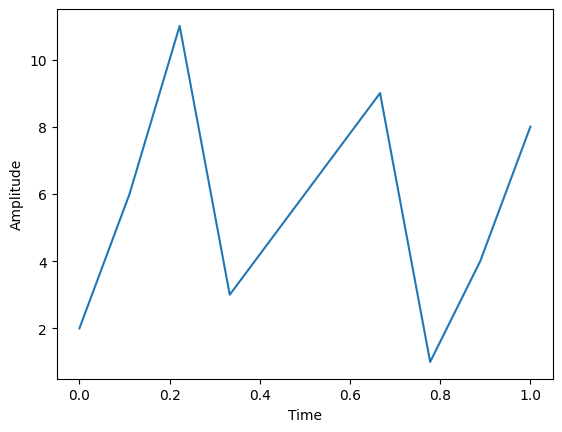

In [6]:
# create a signal and plot its dft
import numpy as np
import matplotlib.pyplot as plt

# create a signal
t = np.linspace(0, 1, 10)
x = [ 2, 6, 11, 3, 5, 7, 9, 1, 4, 8]
# plot the signal
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [4]:
import math
import random

def fabs(x):
    return abs(x)

def sqrt(x):
    return x**0.5

def exp(x):
    return math.e**x

def pow(x, y):
    return x**y

def log(x, base):
    return math.log(x, base)

def fmod(x, y):
    return x % y

def ceil(x):
    return math.ceil(x)

def floor(x):
    return math.floor(x)

def trunc(x):
    return math.trunc(x)

# define constants
pi = math.pi
e = math.e

def radians(x):
    return x * pi / 180

def degrees(x):
    return x * 180 / pi

def sin(x):
    return math.sin(x)

def cos(x):
    return math.cos(x)

def tan(x):
    return math.tan(x)

def asin(x):
    return math.asin(x)

def acos(x):
    return math.acos(x)

def atan(x):
    return math.atan(x)

def atan2(y, x):
    return math.atan2(y, x)

def random():
    return random.random()

def uniform(a, b):
    return random.uniform(a, b)

def randint(a, b):
    return random.randint(a, b)

def choice(seq):
    return random.choice(seq)

def randrange(start, stop=None, step=1):
    return random.randrange(start, stop, step)

def seed(x=None):
    random.seed(x)


def rounds(x, n):
    if isinstance(x, complex):
        return complex(round(x.real, n), round(x.imag, n))
    else:
        return round(x)

def cexp(x):
    return complex(exp(x.real) * cos(x.imag), exp(x.real) * sin(x.imag))



[(56+0j), (-1.60081-5.0328j), (2.28115-4.84104j), (-13.89919+10.99641j), (-7.78115+3.57971j), (6-0j), (-7.78115-3.57971j), (-13.89919-10.99641j), (2.28115+4.84104j), (-1.60081+5.0328j)]


C:\Users\sanji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


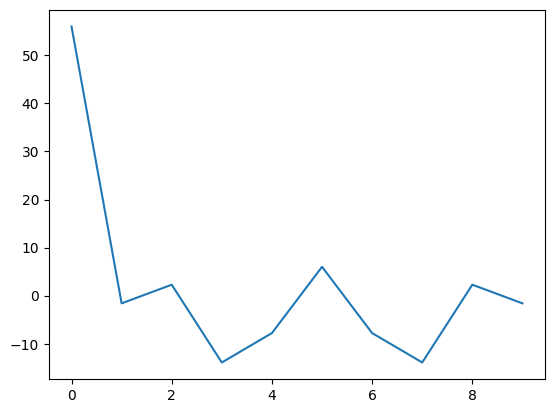

In [13]:
# dft Function
pi = np.pi
def DFT(f, N):
    result = []
    for k in range(N):
        sum = 0
        for n in range(len(f)):
            sum += complex(f[n]) * cexp(-1j * 2 * pi * k * n / N)
        result.append(rounds(sum, 5))
    return result

# plot the dft
plt.plot(DFT(x, 10))
print (DFT(x, 10))

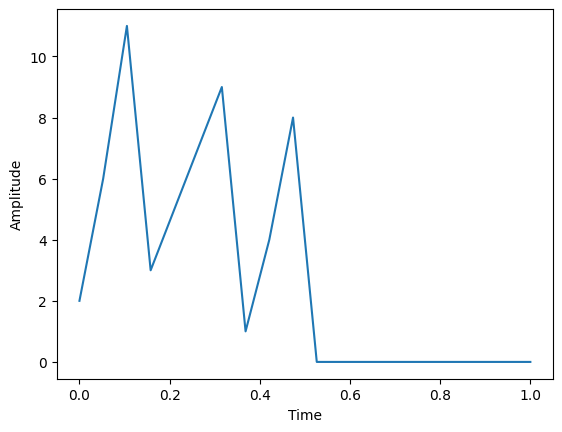

[(56+0j), (5.70051-36.69388j), (-1.60081-5.0328j), (-0.00473-11.59916j), (2.28115-4.84104j), (-9-17j), (-13.89919+10.99641j), (6.15063+0.47455j), (-7.78115+3.57971j), (7.15359+7.56926j), (6-0j), (7.15359-7.56926j), (-7.78115-3.57971j), (6.15063-0.47455j), (-13.89919-10.99641j), (-9+17j), (2.28115+4.84104j), (-0.00473+11.59916j), (-1.60081+5.0328j), (5.70051+36.69388j)]


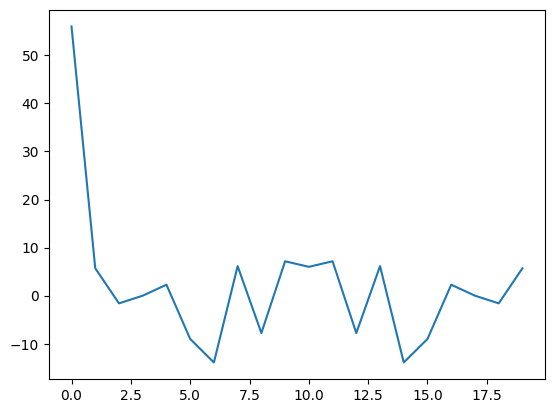

In [14]:
# zero pad the signal
t = np.linspace(0, 1, 20)
x = [ 2, 6, 11, 3, 5, 7, 9, 1, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# plot the zero padded signal
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# plot the dft
plt.plot(DFT(x, 20))
print (DFT(x, 20))


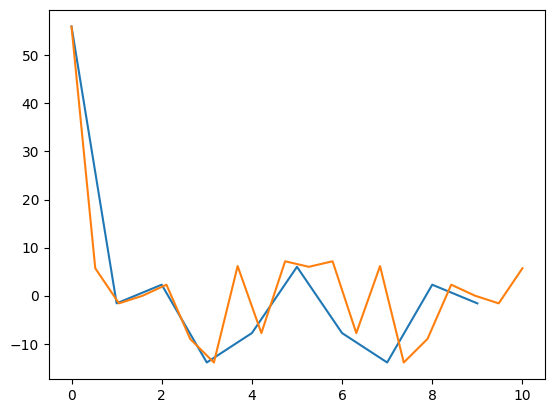

In [19]:
# Create another signal x
t = np.linspace(0, 1, 10)
x = [ 2, 6, 11, 3, 5, 7, 9, 1, 4, 8]
# plot the signal
plt.plot(DFT(x, 10))
# Zero pad the signal
t = np.linspace(0, 10, 20)
x = [ 2, 6, 11, 3, 5, 7, 9, 1, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# plot the zero padded signal
plt.plot(t, DFT(x, 20) )